# Reference Evapotranspiration Comparison: State Mesonet vs pyFAO56
This Jupyter Notebook contains a script to compare a state's Mesonet calculation of reference evapotranspiration (ETr or ETo) with the reference ET calculated using the FAO-56 Penman-Monteith equation, via a python package pyfao56. 
Using Hourly or Daily data, fill out the columns in the respective excel template, and run the script below. 

In [162]:
# Required packages for the script
import pyfao56 as fao
from pyfao56 import tools
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Alter the information below to find your inputted data. 

In [163]:
# Import the weather data from your Excel file
input_file = 'input/CO/SLD01_2023.xlsx'
output_path = 'output/CO/'

# Time format of your data? Daily or Hourly
time_format = 'Hourly'

# Do you want to make a pyfao56 Weather Object? True/False
make_wth = False

# Enter a comment for file export names
comment = 'SLD01'
state = 'CO'


# Weather station Parameters:

# Height of the Reference Crop, "T" for alfalfa or "S" for grass
rfcrp = "T"

# Elevation, Latitude, and Longitude of the Weather Station
z     = 2202.79
lat   = 38.5713
lon   = -106.0427

# Longitude of the center of the local time zone
lzn = -106

# Enter the height of the wind measurement at your station (m)
wndht = 2

# Run All cells, and it will create files in the output folder

In [164]:
# Create a dataframe
input_df = pd.read_excel(input_file, time_format)
# Remove unit row from the dataframe:
input_df = input_df.iloc[1:]
input_df.reset_index(drop=True, inplace=True)

In [165]:
def compute_et_hourly(df,rfcrp,z,lat,lon,lzn,wndht,comment):
    print('Hourly')
    # Change the data types of the dataframe columns
    d_types = {'Date and Time':     'datetime64[ns]',
                'Air Temp':         'float64',
                'Relative Humidity':'float64',
                'Dewpoint':         'float64',
                'Vapor Pressure':   'float64',
                'Solar Rad':        'float64',
                'Precip':           'float64',
                'Wind Speed':       'float64',
                'ETr':              'float64',
                'ETo':              'float64'}
    for col, dtype in d_types.items():
        df[col] = df[col].astype(dtype)
        
    # Rename columns to FAO56:
    df.rename(columns={'Date and Time': 'Timestamp',
                        'Solar Rad': 'Srad',
                        'Air Temp': 'T',
                        'Vapor Pressure': 'Vapr',
                        'Dewpoint': 'Tdew',
                        'Relative Humidity': 'RH',
                        'Wind Speed': 'Wndsp',
                        'Precip': 'Rain'}, inplace=True)

    # Add Standard Clock Time (SCT) @ midpoint of the period
    # SCT is determined by the hour of the datetime object, with an
    # adjustment of -0.5 for all hours except midnight (0), for
    # which the SCT is set to 23.5.
    compute_sct = lambda DT: 23.5 if DT.hour == 0 else DT.hour - 0.5
    df['SCT'] = df['Timestamp'].apply(compute_sct)
    
    
    # pyfao56 returns cloudiness values (fcd) for next timestep
    # fcd should make the calculations more accurate, so we use it
    fcd_list = np.empty(len(df))
    fcd_list.fill(np.nan)
    # Loop through the dataframe to compute refET for each hour
    et = np.empty(len(df))
    et.fill(np.nan)
    for row in df.itertuples():
        idx = row.Index
        prev_step = idx -1
        temp = df['T'][idx]
        rh = df['RH'][idx]
        vapr = df['Vapr'][idx]
        srad = df['Srad'][idx]
        tdew = df['Tdew'][idx]
        wind = df['Wndsp'][idx]
        rain = df['Rain'][idx]
        doy = df['DOY'][idx]
        sct = df['SCT'][idx]
        time = df['Timestamp'][idx]
        if idx == 0:
            fcd = 1.0
        else:
            fcd = fcd_list[prev_step]
        # Checking for bad / missing data
        values = [temp, rh, tdew, vapr, srad, rain, wind]
        if -999 in values:
            print(f"Timestamp {time} is missing data.")
            continue
        et_tuple = fao.refet.ascehourly(rfcrp=rfcrp,z=z,lat=lat,lon=lon,lzn=lzn,
                                        doy=doy,sct=sct,israd=srad,tavg=temp,
                                        vapr=vapr,tdew=tdew,rhum=rh,wndsp=wind,
                                        wndht=wndht,tl=1.0,csreq='D',fcdpt=fcd)
        fcd_list[idx] = et_tuple[1]
        et[idx] = et_tuple[0]
    df['refET'] = et

    # Group by day
    daily_df = df.groupby(
        df['Timestamp'].dt.date).agg(
            {'Srad': 'sum', 'T': ['max', 'min'], 'Vapr': 'mean', 
            'Tdew': 'mean', 'RH': ['max', 'min'],'Wndsp': 'mean', 
            'Rain': 'sum', 'ETr': 'sum', 'ETo': 'sum', 'refET': 'sum'})
    # Drop level of column indexing (necessary after using groupby)
    daily_df = daily_df.droplevel(1, axis=1)
    # Rename cols after grouping by date
    daily_df.columns = [f'c{i}' for i in range(1, daily_df.shape[1]+1)]
    column_names = {daily_df.columns[0]: 'Srad',
                    daily_df.columns[1]: 'Tmax',
                    daily_df.columns[2]: 'Tmin',
                    daily_df.columns[3]: 'Vapr',
                    daily_df.columns[4]: 'Tdew',
                    daily_df.columns[5]: 'RHmax',
                    daily_df.columns[6]: 'RHmin',
                    daily_df.columns[7]: 'Wndsp',
                    daily_df.columns[8]: 'Rain',
                    daily_df.columns[9]: 'ETr',
                    daily_df.columns[10]:'ETo',
                    daily_df.columns[11]:'refET'}
    daily_df.rename(columns=column_names, inplace=True)
    daily_df.reset_index(inplace=True)
    
    return df,daily_df

In [166]:
def compute_et_daily(df,rfcrp,z,lat,wndht,comment):
    print('Daily')
    # Change the data types of the dataframe columns
    d_types = {'Date':             'datetime64[ns]',
               'DOY':              'int64',
               'Max Temp':         'float64',
               'Min Temp':         'float64',
               'RH Max':           'float64',
               'RH Min':           'float64',
               'Dewpoint':         'float64',
               'Vapor Pressure':   'float64',
               'Solar Rad':        'float64',
               'Precip':           'float64',
               'Wind Speed':       'float64',
               'ETr':              'float64',
               'ETo':              'float64'}
    for col, dtype in d_types.items():
        df[col] = df[col].astype(dtype)
        
    # Rename columns to FAO56:
    df.rename(columns={
        'Date': 'Timestamp',
        'Solar Rad': 'Srad',
        'Max Temp': 'Tmax',
        'Min Temp': 'Tmin',
        'RH Max': 'RHmax',
        'RH Min': 'RHmin',
        'Vapor Pressure': 'Vapr',
        'Dewpoint': 'Tdew',
        'Wind Speed': 'Wndsp',
        'Precip': 'Rain'}, inplace=True)
    # Loop through the dataframe to compute refET for each day
    et = np.empty(len(df))
    et.fill(np.nan)
    for row in df.itertuples():
        idx = row.Index
        doy = df['DOY'][idx]
        tmax = df['Tmax'][idx]
        tmin = df['Tmin'][idx]
        rhmax = df['RHmax'][idx]
        rhmin = df['RHmin'][idx]
        vapr = df['Vapr'][idx]
        srad = df['Srad'][idx]
        tdew = df['Tdew'][idx]
        wind = df['Wndsp'][idx]
        rain = df['Rain'][idx]
        date = df['Timestamp'][idx]
        # Checking for bad / missing data
        values = [tmax, tmin, rhmax, rhmin, tdew, vapr, srad, rain, wind]
        if -999 in values:
            print(f"Date {date} is missing data.")
            continue
        etsz = fao.refet.ascedaily(rfcrp=rfcrp,z=z,lat=lat,doy=doy,
                                       tmax=tmax,tmin=tmin,rhmax=rhmax,
                                       rhmin=rhmin,vapr=vapr,israd=srad,
                                       tdew=tdew,wndsp=wind,wndht=wndht)
        et[idx] = etsz
    df['refET'] = et

    return df

In [167]:
def to_wth(df,comment):
    
    df['YYYY-DOY'] = pd.to_datetime(df['Date'])
    df.index = df['YYYY-DOY'].dt.strftime('%Y-%j')
    df.drop(['Date', 'YYYY-DOY'], axis=1, inplace=True)
    df.index.name = None
    # Add "M or P" column
    df['MorP'] = 'M'
    # Drop -999 and NaN values values:
    df = df[df != -999].dropna()
    # Create Weather class and save file
    wth = fao.Weather()
    wth.wdata = df
    wth.savefile(f'{output_path}/{comment}.wth')

In [168]:
def _kge(s,m):
        """
        Compute the Kling-Gupta (2011) efficiency (kge).
        Presently not a feature in pyfao56, soon to be added.
        """
        stats = tools.Statistics(simulated=s, measured=m)
        r = stats._r(s,m)
        beta = np.mean(s)/np.mean(m)
        alpha = np.std(s)/np.std(m)
        a = (r-1.0)*(r-1.0)
        b = (alpha-1.0)*(alpha-1.0)
        c = (beta-1.0)*(beta-1.0)
        return 1.0-np.sqrt(a+b+c)

### Comparison of pyfao56 and Mesonet ET values
# The input dataframe requires columns for refET from pyfao56 and Mesonet ET
# The comment is added to the plot title and file name
def compute_statistics(df,rfcrp,comment):
    if rfcrp == 'T':
        df['Mesonet ET'] = df['ETr']
        et = 'ETr'
    elif rfcrp == 'S':
        df['Mesonet ET'] = df['ETo']
        et = 'ETo'
    if time_format == 'Hourly':
        tf = 'Hourly Sum'
    else: 
        tf = 'Daily'
    stat_df = df
    # Computing statistical differences between pyfao56 and Mesonet
    statistics = tools.Statistics(simulated=list(stat_df['refET']), 
                                measured=list(stat_df['Mesonet ET']))
    r2 = statistics._r2(s=stat_df['refET'], m=stat_df['Mesonet ET'])
    rmse = statistics._rmse(s=stat_df['refET'], m=stat_df['Mesonet ET'])
    bias = statistics._bias(s=stat_df['refET'], m=stat_df['Mesonet ET'])
    nse = statistics._nse(s=stat_df['refET'], m=stat_df['Mesonet ET'])
    kge = _kge(s=stat_df['refET'], m=stat_df['Mesonet ET'])

    
    # Plotly figure
    fig = go.Figure(data=go.Scatter(x=stat_df['refET'], 
                                    y=stat_df['Mesonet ET'],
                                    mode='markers',
                                    hovertext=stat_df['Timestamp'],
                                    hoverinfo='text+x+y',))

    # Add line where x = y
    fig.add_trace(go.Scatter(
        x=[stat_df['refET'].min(), stat_df['refET'].max()],
        y=[stat_df['refET'].min(), stat_df['refET'].max()],
        mode='lines',
        line=dict(color='gray', dash='dash'),
        showlegend=False
    ))

    # Add labels and title
    fig.update_layout(
        xaxis_title=f'pyfao56 {et}',
        yaxis_title=f'Mesonet {et}',
        title=f'{state}-{comment} {tf} {et}'
    )
    # Add annotations (box with text)
    fig.update_layout(
        annotations=[
            dict(
                x=1,
                y=0.8,
                xref="paper",
                yref="paper",
                text=f"R2: {r2:.2f}<br>" \
                    f"RMSE: {rmse:.2f}<br>Bias: {bias:.2f}<br>" \
                    f"NSE: {nse:.2f}<br>KGE: {kge:.2f}<br>",
                showarrow=False,
                align="left",
                font=dict(size=12)
            )
        ]
    )

    # Show the plot
    fig.write_html(f'{output_path}/pyfao56_vs_Mesonet_{comment}_{et}.html')
    fig.show()
    # Save the dataframe
    stat_df.to_csv(f'{output_path}/pyfao56_vs_Mesonet_{comment}_{et}.csv')

Hourly


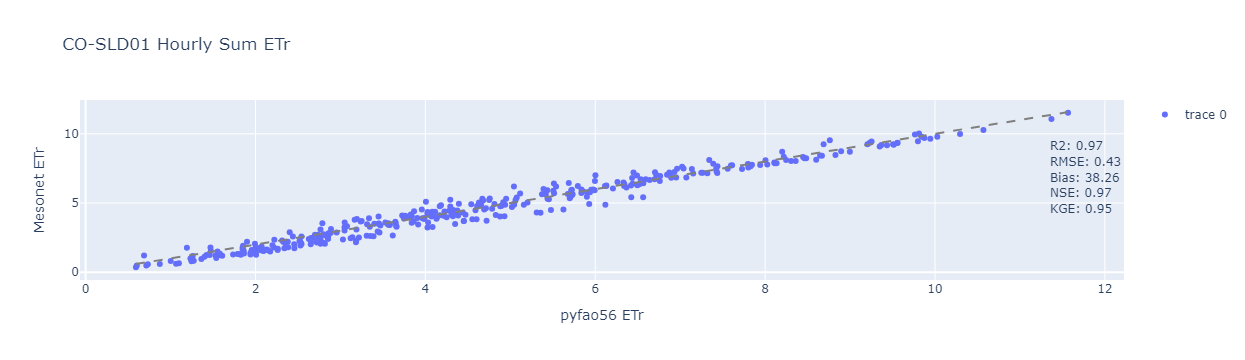

Complete!


In [169]:
# Run the earlier functions
if time_format == 'Hourly':
    hourly_df, daily_df = compute_et_hourly(input_df, rfcrp, z, lat, lon, lzn, wndht, comment)
    if make_wth:
        to_wth(daily_df,comment)
    
elif time_format == 'Daily':
    daily_df = compute_et_daily(input_df, rfcrp, z, lat, wndht, comment) 
    if make_wth:
        to_wth(daily_df,comment)   
compute_statistics(daily_df,rfcrp,comment)
print('Complete!')